# Entrega final - Competencia 02 de Kaggle

Incluye:

- Explicación de los procesos afectuados
- Justificación de selección del "mejor" modelo
- Entrega adicional con promedios entre semilleríos

Alumno: Santiago Tedoldi

Comisión lunes

In [ ]:
# Librerias
import pandas as pd
import numpy as np

## Explicación de los procesos

### Definición del target

Trabajé usando un script de SQL con duckdb, según lo visto en la comisión de los lunes:

Notebook: comp02_target

### Preprocesamiento de los datos (prepro)

Tomando de base lo visto en la comisión de los lunes, y con ayuda de los notebooks de Ian Michel Link, evalué la calidad de los datos (nulos, zeros) y el data drifting observando los **últimos 6 meses de datos**.

Además, a las variables monetarias les aplique un proceso de corrección por deflación.

Obtuve dos conjuntos de datos:

- Regular, limpiando data drifting con psi > 0.1
- X, limpiando data drifting con psi > 0.2

Notebook: comp02_prepro_6, comp02_prepro_6x

### Ingeniería de variables (fe)

Utilicé dos aproches diferentes, según consumía los datos Regular o los X.

- **fe conceptual**, creando variables "claves" de 1 a 6 meses para: lags, deltas, slopes y ntiles10 (~400 variables)
- **fex (conceptual + masivo)**, agregando para las demás variables lags y deltas de un mes previo. (~660 variables)

### Optimización bayesiana (opt)

Trabajé con optuna, optimizando de forma local (con solo 3 meses de datos) y solo con el set de train regular con fe conceptual (~400 variables).

Optimicé dos modelos candidatos:

> lightgbm prepro6 fe6 y 3 opt (local opt)

In [ ]:
# Mejores parámetros

{'n_estimators': 466, 
 'num_leaves': 57, 
 'learning_rate': 0.024563319625208798, 
 'min_data_in_leaf': 100, 
 'min_gain_to_split': 0.011030284732349089, 
 'feature_fraction': 0.5157056981996073, 
 'bagging_fraction': 0.8424259086760796, 
 'bagging_freq': 2, 
 'max_bin': 97}

En un back-testing de [202101, 202102, 202103, 202104] vs 202106:

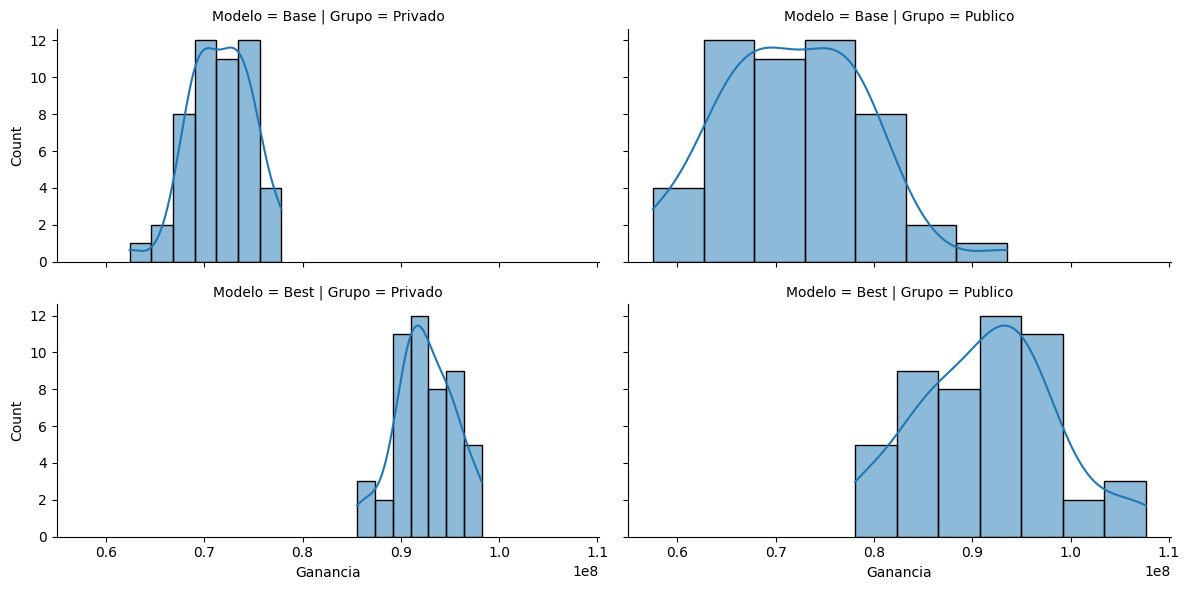

> xgboost prepro6 fe6 y 3 opt (local opt)

In [ ]:
# Mejores parámetros

{'n_estimators': 464, 
 'max_leaves': 228, 
 'eta': 0.026841741174110256, 
 'gamma': 0.6065611085207565, 
 'min_child_weight': 10, 
 'subsample': 0.8649413237261332, 
 'colsample_bytree': 0.5013152719066779}

En un back-testing de [202101, 202102, 202103, 202104] vs 202106:

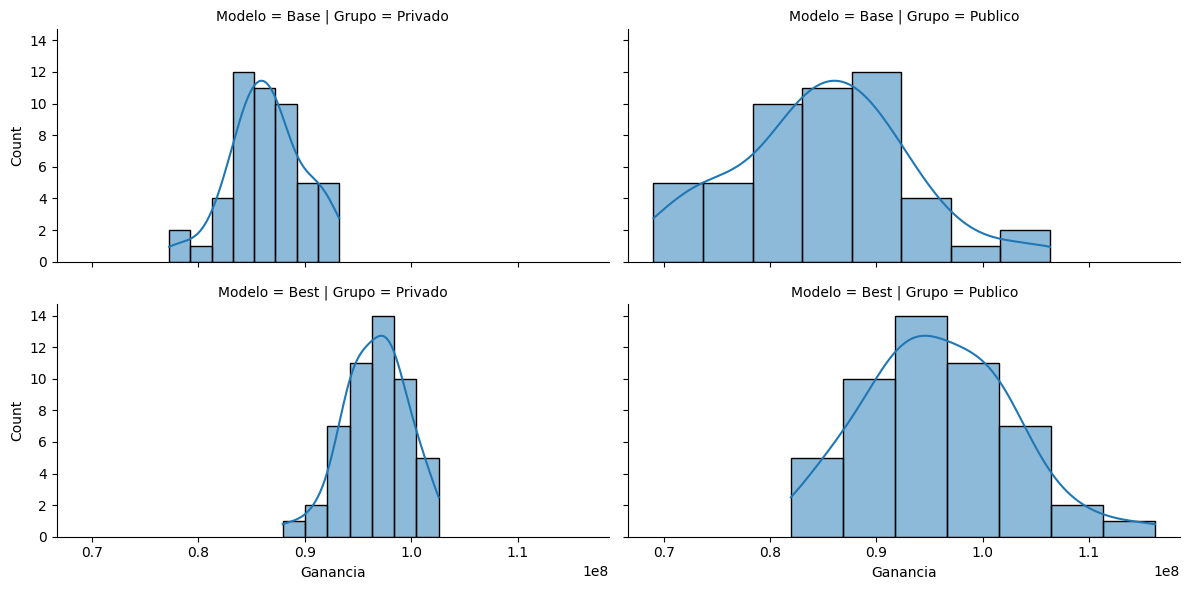

## Justificación de selección

Pretendiendo identificar el mejor modelo con comparación de pipelines y backtesting.

### Comparación de pipelines

Notebook: comp02_pipeline_comp

Comparando los modelos optimizados en un back-testing de [202101, 202102, 202103, 202104] vs 202106:

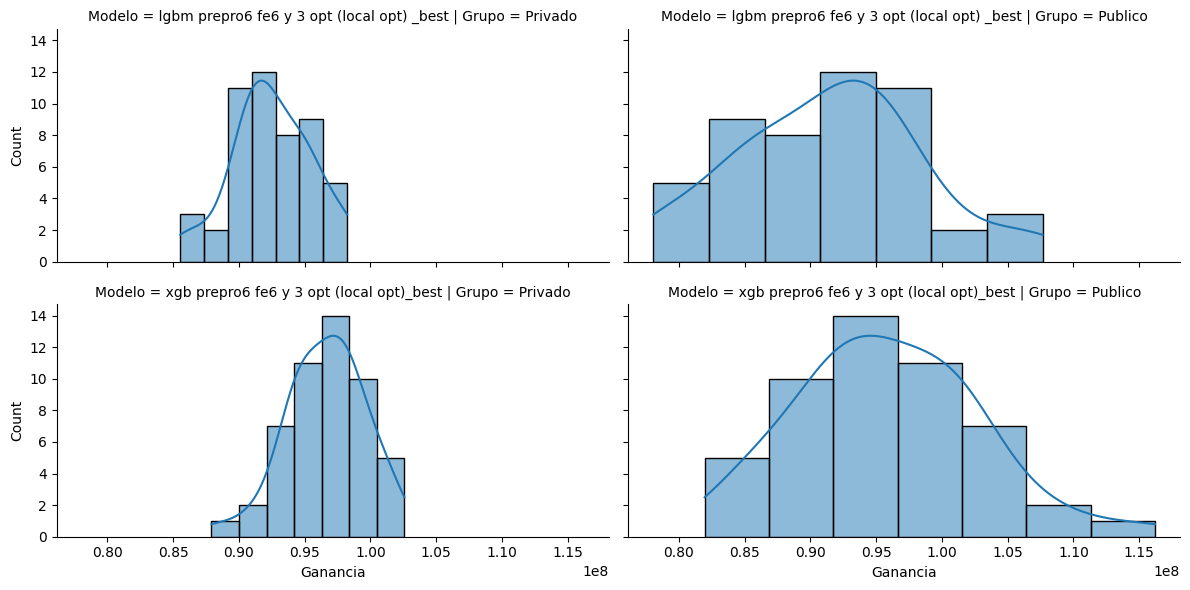


Con un test U de Mann-Whitney (no paramétrica) que compara dos muestras para determinar si hay diferencias:

> Resultado del test(privado):

Estadístico U = 415.5

P-valor = 4.474539994580602e-09

Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt)_priv es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _priv.

> Resultado del test (publico):

Estadístico U = 823.5

P-valor = 0.0016578876183399318

Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgb prepro6 fe6 y 3 opt (local opt)_pub es mayor que la de lgbm prepro6 fe6 y 3 opt (local opt) _pub.

> CONCLUSION:

Se optó por elegir el xgb sobre el lgbm.



### Back-testing comparando meses

Elegido el modelo **xgboost prepro6 fe6 y 3 opt (local opt)**, procedí a evaluar la cantidad de meses a agregar en el train, que correspondía con un mejor rendmiento del modelo.

¿Cuantos meses vale la pena considerar en el train?

- 4 vs. 6 meses

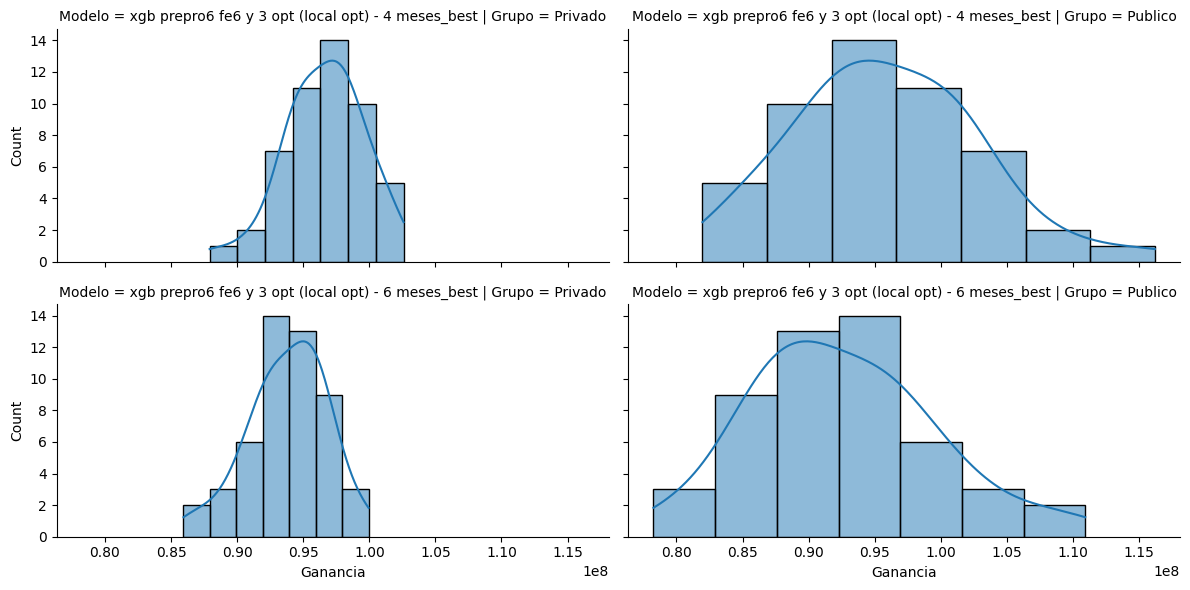

Mejor 4 que 6...

- 4 vs. 8 meses

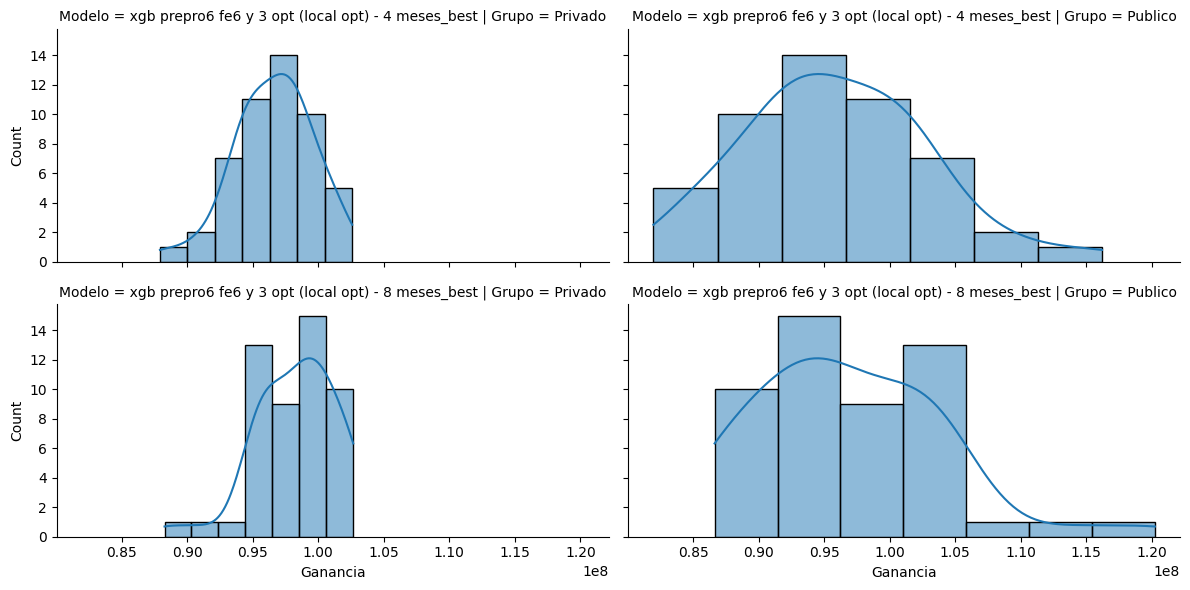

Mejor 8 que 4...

- 8 vs. 10 meses

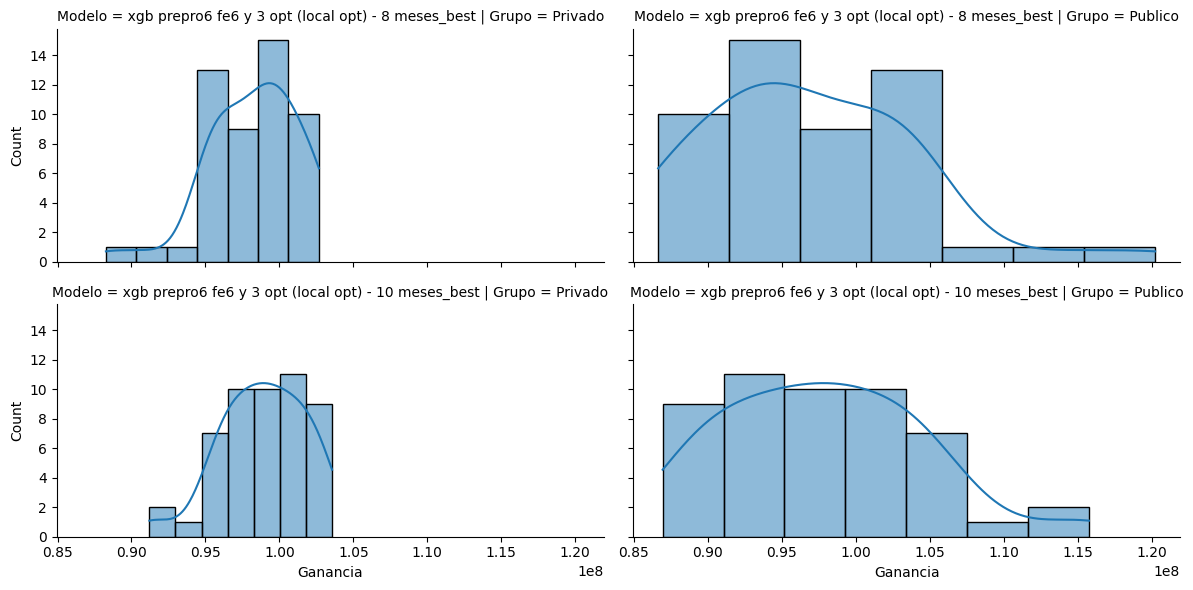

Parece parejo entre 8 y 10 meses.

> CONCLUSIÓN:

Usar 9 meses en el train debería ser suficiente.

### Back-testing para modelo semillerio

Tomando como base el modelo semillerio, mostrado por el Profesor en la clase plenaria, que se encuentra optimizado para trabajar con 100 semillas.

Como trabajé sobre un set de datos con fe conceptual, asumiento que el Profesor tenía más cantidad de variables, apliqué un "correctivo" al feature_fraction:

In [ ]:
{'n_estimators': 23,
 'num_leaves': 32,
 'learning_rate': 0.34,
 'min_data_in_leaf': 711,
 'feature_fraction': 2*0.2, # x2 para tratar de compenzar la falta de variables
 'extra_trees': False,
}

Procedí a evaluar la cantidad de meses a agregar en el train, que correspondía con un mejor rendmiento del modelo semillerio.

> CONCLUSION:

La optimización del modelo hecha por el Profesor resultó ser buena (mejor que el modelo base) para 8 y 10 meses de train. No así para 6 meses, donde el modelo base y el semillerío eran casi idénticos.

Todo esto, entrenando con una única semilla.

Luego, parece razonable entrenar un semillerio con 9 meses, al igual que el modelo optimizado xgb.

Notebook: comp02_pipeline_comp con sem y comp02_pipeline_comp con semx



### Back-testing para evaluar el umbral y comparar modelos

**Modelo xgb optimizado**

Se entrenaron 50 modelos (variando semilla) con back-testing [202101, 202102, 202103, 202104] vs 202106.

El umbral óptimo de estos modelos resulto ser:

- Umbral óptimo promedio: 0.0156
- Umbral óptime mediano: 0.0148

Notebook: comp02_back-testing

### Back-testing para evaluar semillerios

#### Datos regulares

Notebook: comp02_back-testing con sem

**Modelo xgb optimizado**

10 semilleríos de 15 semillas, muy costoso de entrenar por el tamaño del modelo (~450 árboles).

De estas 150 iteraciones, agrupadas en promedio de a 15, se observa un umbrál optimo entre 0.013 y 0.016, con ganancias máximas del orden de 96 a 97 millones.

**Modelo semillerio** modificado

'feature_fraction': 2*0.2

15 semillerios de 25 semillas:

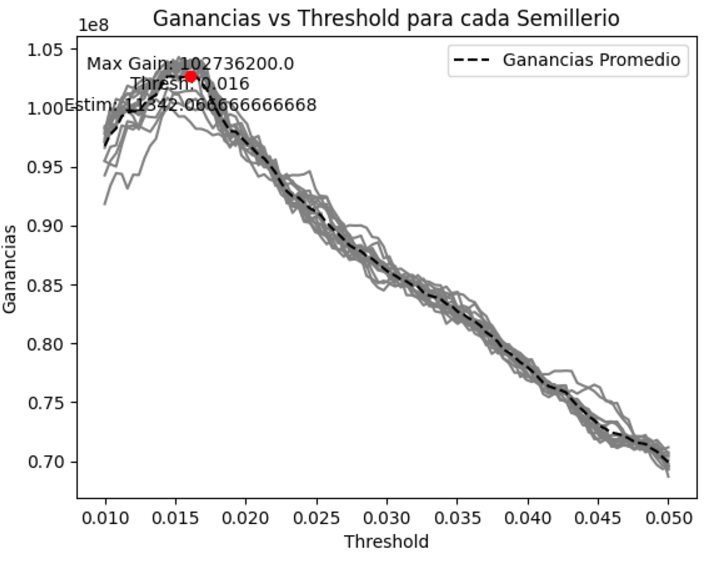

10 semillerios de 25 semillas:

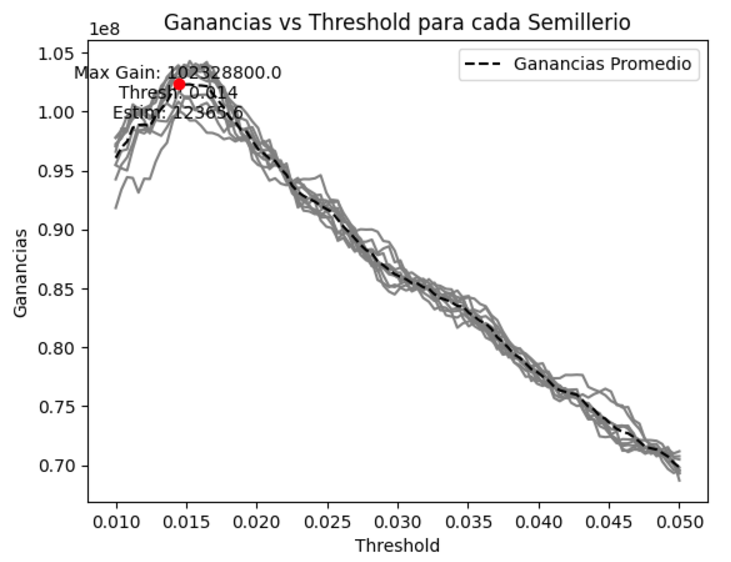

#### Datos X

10 semillerios de 25 semillas

Agregando variables según lo mencionado

Notebook: comp02_back-testing con semx

**Modelo semillerio** modificado

'feature_fraction': 2*0.2

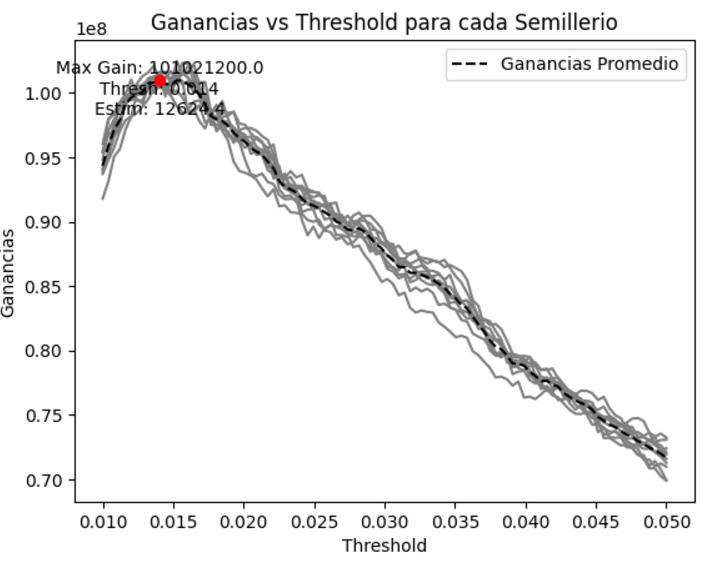

**Modelo semillerio** original

'feature_fraction': 0.2, al contar con más variables

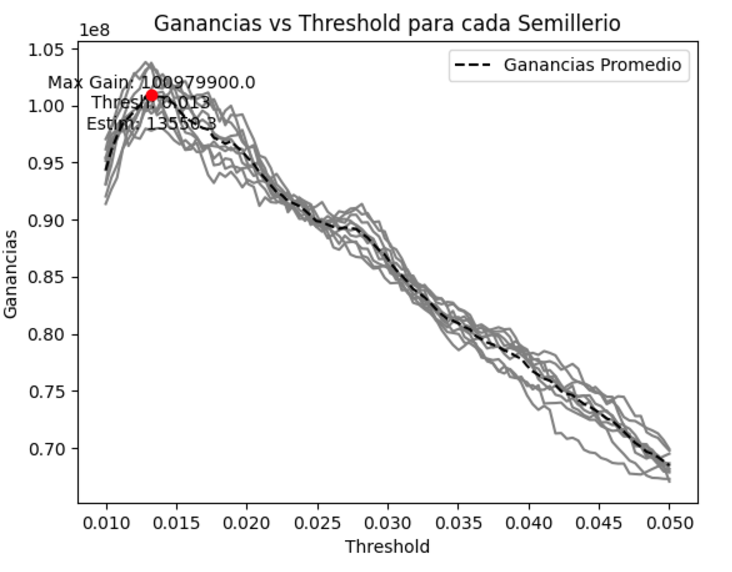

## Conclusiones finales

Los modelos semillerios parecen superar por un 4 ~ 5 % al modelo xgb optimizado.

Entre los modelos semillerios:

- Las mayores ganancias las dan los modelos con **datos regulares**, aunque los semillerios menos performantes se comparen con los entrenados con **datos x**.

- El semillerio original, con **datos x** parece más "inestable" que el mismo modificado, lo que se explica por el hiperparámetro modificado.

Dicho esto, 

### Modelo elegido

> **Modelo semillerio** modificado con datos regulares

"pred_lgbm_mod_pr6_fe6_tr9_sem100_24T-11-202417-29-53.csv"

Notebook: comp02_prediccion (segundo modelo entrenado y ejecutado para predecir)

## Mejunje de semillerios

Ante la afirmación de que combinar modelos diferentes puede traer mejor rendimiento, procedo a hacer un rejunte de probas de distintos modelos semillerios:

- xgb optimizado 25 semillas, datos regulares
- lgbm semillerio profe mod, 100 semillas, datos regulares (elegido como entrega única)
- lgbm semillerio profe original, 100 semillas, datos x

In [25]:
xgb_probas = 'predicciones/probas/probas_pred_xgb_pr6_fe6_op3_tr9_sem10_24T-11-202416-43-48.csv'
lgbm_mod_probas = 'predicciones/probas/probas_pred_lgbm_mod_pr6_fe6_tr9_sem100_24T-11-202417-29-53.csv'
lgbm_orix_probas = 'predicciones/probas/probas_pred_lgbm_pr6_fe6x_tr9_sem100_24T-11-202415-47-58.csv'

columns = ['client', 'proba_sem_mean']

df_xgb_probas = pd.read_csv(xgb_probas,usecols=columns)
df_lgbm_mod_probas = pd.read_csv(lgbm_mod_probas,usecols=columns)
df_lgbm_orix_probas = pd.read_csv(lgbm_orix_probas,usecols=columns)

df_mejunje = df_xgb_probas.merge(df_lgbm_mod_probas, on='client', suffixes=("_xgb","_lgbm_mod"))
df_mejunje = df_mejunje.merge(df_lgbm_orix_probas, on='client', how='left')

df_mejunje.rename(columns={'proba_sem_mean': 'proba_sem_mean_lgbm_orix'}, inplace=True)

In [26]:
df_mejunje

,client,proba_sem_mean_xgb,proba_sem_mean_lgbm_mod,proba_sem_mean_lgbm_orix
0,874396751,0.000189,0.000169,0.000163
1,433266268,0.000515,0.000843,0.001019
2,602940488,0.001893,0.002509,0.001931
3,311885150,0.000973,0.001813,0.000974
4,561051836,0.000367,0.000587,0.000493
...,...,...,...,...
165437,304459714,0.002948,0.001576,0.002026
165438,298978008,0.000208,0.000161,0.000187
165439,477851904,0.001995,0.001839,0.002163
165440,872832537,0.000529,0.000320,0.000416


In [36]:
proba_s_columns = df_mejunje.filter(regex='^proba_sem_mean_')
proba_s_mean = proba_s_columns.mean(axis=1)

df_mejunje['proba_sem_mean_all'] = proba_s_mean

# Umbral
thr_opt_sem = 0.015

# Prediccion
df_mejunje['pred'] = np.where(df_mejunje.proba_sem_mean_all >= thr_opt_sem, 1, 0)

In [37]:
submission = pd.DataFrame({
    'numero_de_cliente': df_mejunje.client.values,
    'Predicted': df_mejunje['pred'].values
})

# Imprimir value counts de las predicciones
value_counts = submission['Predicted'].value_counts()
total_count = len(submission)
print("\nValue Counts:")
print(value_counts)
print("\nFrecuencia Relativa:")
print((value_counts / total_count) * 100)

submission.info()


Value Counts:
Predicted
0    152285
1     13157
Name: count, dtype: int64

Frecuencia Relativa:
Predicted
0    92.047364
1     7.952636
Name: count, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165442 entries, 0 to 165441
Data columns (total 2 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   numero_de_cliente  165442 non-null  int64
 1   Predicted          165442 non-null  int32
dtypes: int32(1), int64(1)
memory usage: 1.9 MB


In [31]:
import datetime

ft = "%dT-%m-%Y%H-%M-%S"
t_now = datetime.datetime.now().strftime(ft)

pred_name = f"pred_mejunje_"+t_now+".csv"

# Guardar el DataFrame en un archivo CSV
submission.to_csv('predicciones/'+pred_name, index=False)
print(f"Predicciones guardadas en{'predicciones/'+pred_name}")


Predicciones guardadas enpredicciones/pred_mejunje_24T-11-202418-18-06.csv


La intuición que tengo, según los comentarios de los Profesores, haría que elija esta predicción como entrega final, aunque debí hacer un back-testing acorde para probarlo.

El Profesor sopló que estaba overfitteando con esta entrega, por lo que volví a mi modelo elegido en las conclusiones.

_____